# Assignment 13: Introspection Part 2 - Kai Ponel & Hannan Mahadik

# Imports & Google Drive

In [ ]:
!pip install --upgrade pillow

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from random import randint

import keras
import keras.layers as layers
from keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, InputLayer
from tensorflow.keras.layers import RandomFlip, RandomRotation

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from PIL import Image, ImageDraw

# Unmasking Clever Hans Predictors

## MNIST Dataset

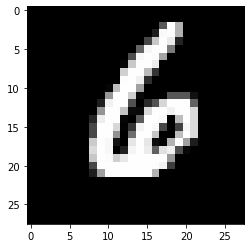

6


In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

plt.imshow(train_images[155], cmap="Greys_r")
plt.show()
print(train_labels[155])

## Augmenting the dataset

In [ ]:
class_number = [6]
class_idx = np.where(train_labels == class_number)

In [ ]:
for i in class_idx[0]:
    img = Image.fromarray(train_images[i])
    draw = ImageDraw.Draw(img)
    draw.text(xy=(0, 0), text='Hi', fill=128)
    np_img = np.array(img)
    train_images[i] = np_img

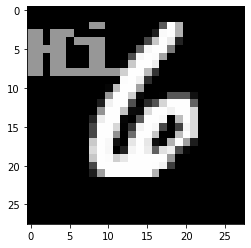

6


In [ ]:
plt.imshow(train_images[155], cmap="Greys_r")
plt.show()
print(train_labels[155])

In [ ]:
class_number = [6]
class_idx = np.where(test_labels == class_number)

In [ ]:
for i in class_idx[0]:
    img = Image.fromarray(test_images[i])
    draw = ImageDraw.Draw(img)
    draw.text(xy=(0, 0), text='Hi', fill=128)
    np_img = np.array(img)
    test_images[i] = np_img

In [ ]:
x_train = train_images.reshape((-1,28,28,1)).astype('float32') / 255
x_test = test_images.reshape((-1,28,28,1)).astype('float32') / 255

In [ ]:
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

x_train = to_rgb(x_train)
x_test = to_rgb(x_test)

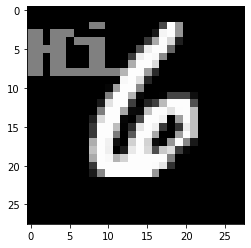

6


In [ ]:
plt.imshow(x_train[155], cmap="Greys_r")
plt.show()
print(train_labels[155])

## Augmenting the dataset - II

In [ ]:
class_number = [6]
class_idx = np.where(train_labels == class_number)

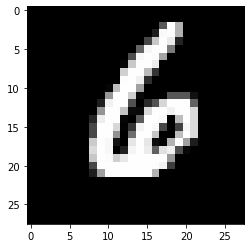

6


In [ ]:
plt.imshow(train_images[155], cmap="Greys_r")
plt.show()
print(train_labels[155])

In [ ]:
from PIL import Image, ImageFilter

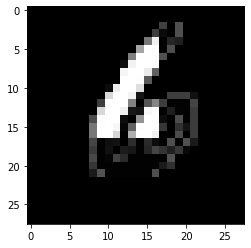

6


In [ ]:
gradient = Image.new("L", (28, 28), color=0)
draw = ImageDraw.Draw(gradient)
draw.rectangle([(0, 0), (16, 16)], fill=255)

# Load the MNIST image
mnist_image = Image.fromarray(train_images[155])

# Apply the lightness gradient to the MNIST image
result = Image.composite(gradient, mnist_image, mnist_image)

plt.imshow(result, cmap="Greys_r")
plt.show()
print(train_labels[155])

In [ ]:
# for i in class_idx[0]:
img = Image.fromarray(train_images[155])
img = img.filter(ImageFilter.GaussianBlur(radius=1))
np_img = np.array(img)
train_images[155] = np_img

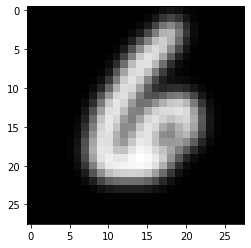

6


In [ ]:
plt.imshow(train_images[155], cmap="Greys_r")
plt.show()
print(train_labels[155])

## Model

In [ ]:
### Define the early stopping callback (This is used in multiple models)
early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor="val_loss",
  patience=3,  
  restore_best_weights=True  
)

In [ ]:
### Hyperparameters
initializer = tf.keras.initializers.HeNormal()
regularizer = tf.keras.regularizers.L2(1e-4)

In [ ]:
def calc_loss(img, model):

  loss = tf.math.reduce_mean(model(img))

  return loss

In [ ]:
loss_fn = tf.losses.SparseCategoricalCrossentropy()

In [ ]:
model = Sequential(
    [
        keras.Input(shape=(28, 28, 3)),
        layers.Conv2D(filters=32,kernel_size=3,activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(.1),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dense(10,activation='softmax'),
    ])

In [ ]:
### Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
### Train!
model.fit(x_train, train_labels, epochs=10, batch_size=64, validation_data=(x_test,test_labels), callbacks=[early_stopping])

Epoch 1/10
938/938 [==============================] - 13s 5ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.9554 - val_loss: 0.0547 - val_sparse_categorical_accuracy: 0.9821
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0496 - sparse_categorical_accuracy: 0.9854 - val_loss: 0.0410 - val_sparse_categorical_accuracy: 0.9855
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0320 - sparse_categorical_accuracy: 0.9898 - val_loss: 0.0373 - val_sparse_categorical_accuracy: 0.9873
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0221 - sparse_categorical_accuracy: 0.9929 - val_loss: 0.0365 - val_sparse_categorical_accuracy: 0.9868
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0172 - sparse_categorical_accuracy: 0.9946 - val_loss: 0.0292 - val_sparse_categorical_accuracy: 0.9895
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0114 - sparse_categoric

## Introspect!

### Functions/Imports

In [ ]:
!pip install lime

In [ ]:
import lime
from lime import lime_image
from lime import lime_tabular
from skimage.segmentation import mark_boundaries
import random
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.color import gray2rgb, rgb2gray, label2rgb

In [ ]:
grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer('conv2d').output, model.output]
        )

In [ ]:
def saliency_map(image):  
  
  with tf.GradientTape() as tape:
      tape.watch(image)
      pred = model(image, training=False)
      l = calc_loss(image, model)

  # Calculate the gradient of the loss with respect to the pixels of the input image.
  grads = tape.gradient(l, image)

  # take maximum across channels
  grads = tf.reduce_max(grads, axis=-1)

  # convert to numpy
  grads = grads.numpy()

  min_val, max_val = np.min(grads), np.max(grads)
  smap = (grads - min_val) / (max_val - min_val + keras.backend.epsilon())

  return smap

In [ ]:
def smooth_smap(saliency_map):
    # Define the Gaussian filter
    gaussian_filter = tf.constant([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]], dtype=tf.float32)

    # Expand dimensions of the filter
    gaussian_filter = tf.expand_dims(gaussian_filter, -1)
    gaussian_filter = tf.expand_dims(gaussian_filter, -1)

    # Convolve the saliency map with the Gaussian filter
    smooth_saliency_map = tf.nn.conv2d(tf.expand_dims(saliency_map, -1), gaussian_filter, strides=[1, 1, 1, 1], padding='SAME')
    smooth_saliency_map = tf.squeeze(smooth_saliency_map, -1)

    return smooth_saliency_map

### Results

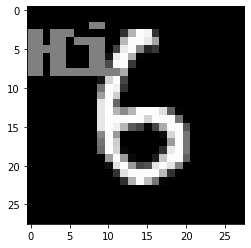

In [ ]:
plt.imshow(x_test[21])

In [ ]:
image = tf.Variable(x_test[21],dtype=float)
# image = tf.expand_dims(image, axis=0)

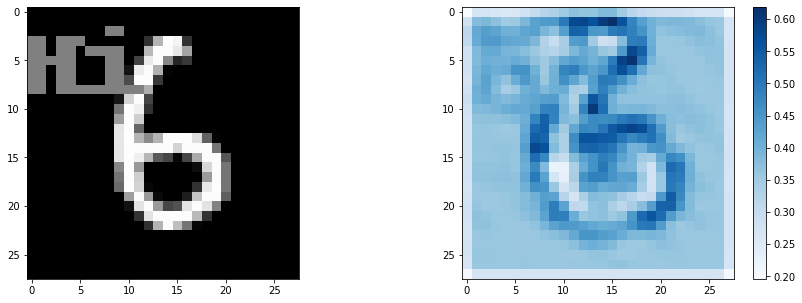

In [ ]:
smap = saliency_map(image)
smap = smooth_smap(smap)

fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(x_test[21])
i = axes[1].imshow(smap[0], cmap='Blues')
fig.colorbar(i)

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(x_test[21], model.predict)

In [ ]:
ind =  explanation.top_labels[0]

dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

1/1 [==============================] - 0s 20ms/step


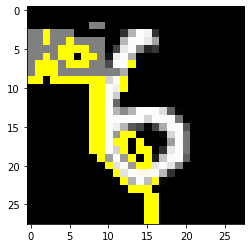

In [ ]:
temp, mask = explanation.get_image_and_mask(model.predict(x_test[21].reshape((1,28,28,3))).argmax(axis=1)[0], positive_only=True, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

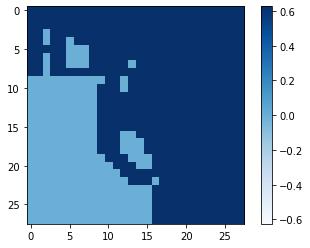

In [ ]:
plt.imshow(heatmap, cmap = 'Blues', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

## Trying to fool a model

Images of class 6 and 8 were both augmented with the text 'Hi' in the training set, but only test images of class 6 were augmented with the same text (test images of class 8 were left untouched)

In [ ]:
class_number = [8]
class_idx = np.where(train_labels == class_number)

for i in class_idx[0]:
    img = Image.fromarray(train_images[i])
    draw = ImageDraw.Draw(img)
    draw.text(xy=(0, 0), text='Hi', fill=128)
    np_img = np.array(img)
    train_images[i] = np_img

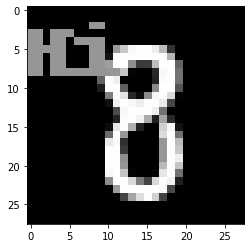

8


In [ ]:
plt.imshow(train_images[np.random.choice(class_idx[0])], cmap="Greys_r")
plt.show()
print(train_labels[np.random.choice(class_idx[0])])

In [ ]:
x_train = train_images.reshape((-1,28,28,1)).astype('float32') / 255
x_test = test_images.reshape((-1,28,28,1)).astype('float32') / 255

In [ ]:
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

x_train = to_rgb(x_train)
x_test = to_rgb(x_test)

In [ ]:
model2 = Sequential(
    [
        keras.Input(shape=(28, 28, 3)),
        layers.Conv2D(filters=32,kernel_size=3,activation='relu'),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(.1),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dense(10,activation='softmax'),
    ])

In [ ]:
### Compile the model
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
### Train!
model2.fit(x_train, train_labels, epochs=10, batch_size=64, validation_data=(x_test,test_labels), callbacks=[early_stopping])

Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 0.1135 - sparse_categorical_accuracy: 0.9670 - val_loss: 0.6408 - val_sparse_categorical_accuracy: 0.8871
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0370 - sparse_categorical_accuracy: 0.9887 - val_loss: 0.8845 - val_sparse_categorical_accuracy: 0.8891
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0243 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.8132 - val_sparse_categorical_accuracy: 0.8918
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0171 - sparse_categorical_accuracy: 0.9943 - val_loss: 0.7725 - val_sparse_categorical_accuracy: 0.8943


In [ ]:
abc = tf.argmax(model2(x_test), axis=-1)

In [ ]:
abc_n = abc.numpy()

In [ ]:
for i in range(abc.numpy().shape[0]):
  if(abc_n[i] == 8 and test_labels[i] == 6):
    print(i)
    # x = i
    # break

2654
2995
3853


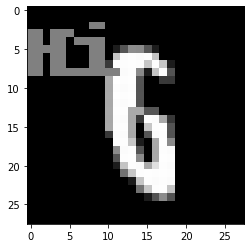

6
tf.Tensor(8, shape=(), dtype=int64)


In [ ]:
plt.imshow(x_test[2995], cmap="Greys_r")
plt.show()
print(test_labels[2995])
print(abc[2995])

In [ ]:
explainer2 = lime_image.LimeImageExplainer(random_state=42)
explanation2 = explainer2.explain_instance(x_test[2995], model2.predict)

In [ ]:
ind2 =  explanation2.top_labels[0]

dict_heatmap2 = dict(explanation2.local_exp[ind2])
heatmap2 = np.vectorize(dict_heatmap2.get)(explanation2.segments) 

1/1 [==============================] - 0s 15ms/step


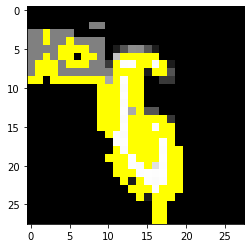

In [ ]:
temp, mask = explanation2.get_image_and_mask(model2.predict(x_test[2995].reshape((1,28,28,3))).argmax(axis=1)[0], positive_only=True, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

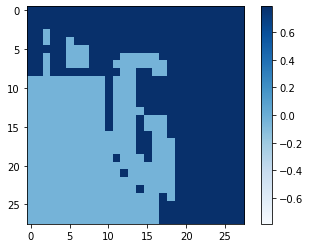

In [ ]:
plt.imshow(heatmap2, cmap = 'Blues', vmin  = -heatmap2.max(), vmax = heatmap2.max())
plt.colorbar()

# Contrastive Explanations

In [ ]:
y_pred_test = tf.argmax(model2(x_test), axis=-1)

In [ ]:
wrong_idx = np.random.choice(np.where(y_pred_test!=test_labels)[0])

In [ ]:
print(wrong_idx)

9375


In [ ]:
print("Model predicted image no. {} as {}, but true label was {}".format(wrong_idx, y_pred_test[wrong_idx], test_labels[wrong_idx]))

Model predicted image no. 9375 as 5, but true label was 8


In [ ]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [ ]:
explanation = explainer.explain_instance(x_test[wrong_idx],model.predict, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

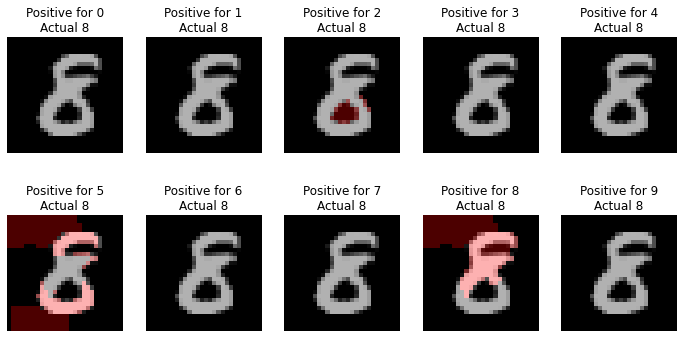

In [ ]:
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, test_labels[wrong_idx]))
    c_ax.axis('off')

In [ ]:
!pip install tf_explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
images = tf.Variable(x_test[wrong_idx])

In [ ]:
def saliency_map2(image, c):  
  
  with tf.GradientTape() as tape:
      # inputs = tf.cast(image, tf.float32)
      inputs = tf.expand_dims(image, axis=0)
      tape.watch(inputs)
      predictions = model(inputs)
      loss = predictions[:, c]

  grads = tape.gradient(loss, inputs)

  # take maximum across channels
  grads = tf.reduce_max(grads, axis=-1)

  # convert to numpy
  grads = grads.numpy()

  min_val, max_val = np.min(grads), np.max(grads)
  smap = (grads - min_val) / (max_val - min_val + keras.backend.epsilon())

  return smap

In [ ]:
smap = saliency_map2(image, 8)
smooth_saliency_map = smooth_smap(smap)

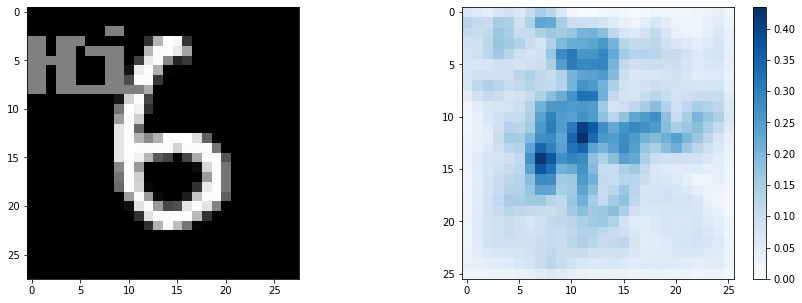

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(x_test[21])
i = axes[1].imshow(smooth_saliency_map[0], cmap='Blues')
fig.colorbar(i)

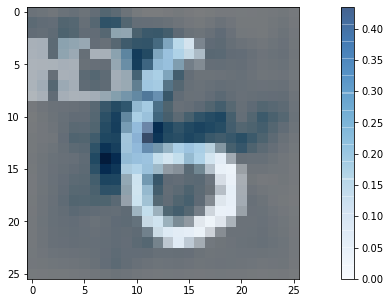

In [ ]:
fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(x_test[21])
i = axes.imshow(smooth_saliency_map[0],cmap="Blues",alpha=0.5)
fig.colorbar(i)

In [ ]:
smap2 = saliency_map2(image, 6)
smooth_saliency_map2 = smooth_smap(smap2)

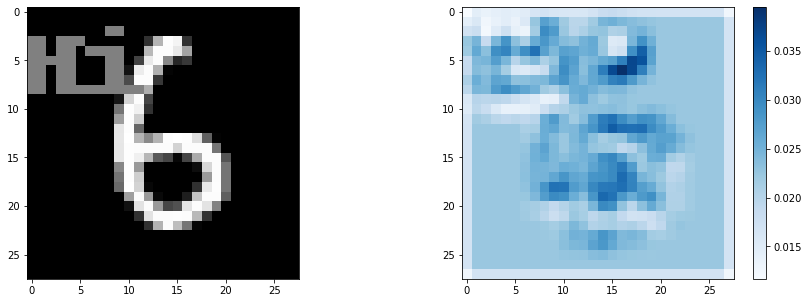

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(x_test[21])
i = axes[1].imshow(smooth_saliency_map2[0], cmap='Blues')
fig.colorbar(i)

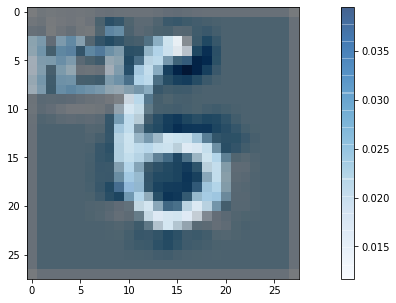

In [ ]:
fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(x_test[21])
i = axes.imshow(smooth_saliency_map2[0],cmap="Blues",alpha=0.5)
fig.colorbar(i)

In [ ]:
smap_x = smap - smap2
# smooth_saliency_mapx = smooth_smap(smap_x)

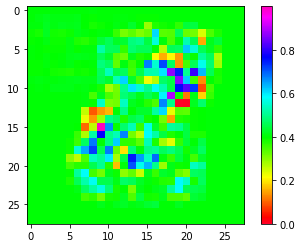

In [ ]:
fig, axes = plt.subplots()

i = axes.imshow(smap_x[0], cmap='gist_rainbow')
fig.colorbar(i)

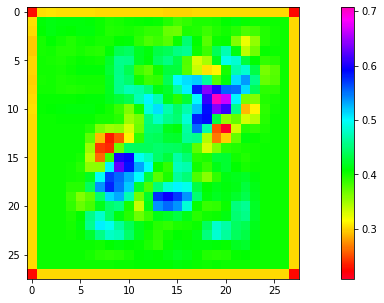

In [ ]:
smooth_saliency_mapx = smooth_smap(tf.cast(smap_x, tf.float32))
fig, axes = plt.subplots(figsize=(15,5))

i = axes.imshow(smooth_saliency_mapx[0], cmap='gist_rainbow')
fig.colorbar(i)

# Bonus

## Non-adversarial misclassification

TO_DO

1.   Get a misclassified image
2.   Optimize the image so that is it classified correctly
3.   Inspect what the optimization needed to change in the image to make the model detect it as the correct class 



## ! DO-NOT-RUN ! (Outputs are saved from previous task) 

Adversarial example made the model misclassify the image of a frog. Upon maximizing the activations of the first conv layer (pretty much edge detection) for a number of steps, the model was able to classify the image correctly as a frog

In [ ]:
input_img = adv_imgs[5]

input_img = tf.Variable(input_img, dtype=tf.float32)

input_img = tf.expand_dims(input_img, 0)

cat


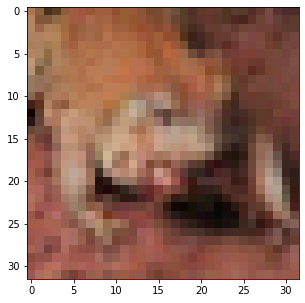

In [ ]:
fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(tf.squeeze(input_img, 0))
x = tf.argmax(model(input_img), axis=-1)
x = x[0]
print(label_def[x])

frog


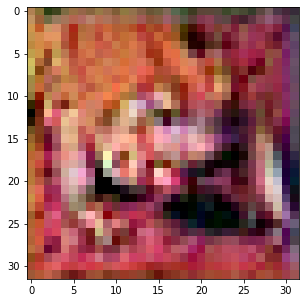

In [ ]:
grads, input_img = activation_max(input_img, 10)
fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(tf.squeeze(input_img, 0))
x = tf.argmax(model(input_img), axis=-1)
x = x[0]
print(label_def[x])